In [22]:
import os
import sys
import json
import time
import requests

from dotenv import load_dotenv

def setup_env():
    
    env_path = os.path.join(os.getcwd(), '../.env')

    if os.path.exists(env_path):
        load_dotenv(dotenv_path=env_path)
        
        print(f"Loaded environment variables from: \033[94m{env_path}\033[0m")
    else:
            print("\033[91mError: .env file not found. Please create one with your OPENAI_API_KEY.\033[0m")
            sys.exit(1)

setup_env()

Loaded environment variables from: /home/ras/0.ai_agent_ws/src/learn_llm/learn_rag_and_agent/../.env


In [23]:
from langchain_teddynote.tools.tavily import TavilySearch

tool = TavilySearch(max_results = 3)

tools = [tool]

print(tool.invoke("대전의 유명한 맛집 Top 3"))

[{'url': 'https://todaytrip.tistory.com/272', 'title': '대전 맛집 베스트10 유명해서 사람들이 많이 방문하는곳 TOP50', 'content': '상세 컨텐츠 · 1. 태화장 · 2. 광천식당 · 3. 에이트 · 4. 온천칼국수 · 5. 반찬식당 · 6. 꾸드뱅 · 7. 농민순대 · 8. 메밀고개 시골막국수.', 'score': 0.8437023, 'raw_content': '# [일상탈출](https://todaytrip.tistory.com/ "일상탈출")\n\n## 고정 헤더 영역\n\n## 메뉴 레이어\n\n### 메뉴 리스트\n\n![N](https://tistory1.daumcdn.net/tistory_admin/blogs/image/category/new_ico_5.gif)\n![N](https://tistory1.daumcdn.net/tistory_admin/blogs/image/category/new_ico_5.gif)\n![N](https://tistory1.daumcdn.net/tistory_admin/blogs/image/category/new_ico_5.gif)\n\n## 검색 레이어\n\n### 검색 영역\n\n## 상세 컨텐츠\n\n### 본문 제목\n\n대전 맛집 베스트10 유명해서 사람들이 많이 방문하는곳 TOP50\n\nby 일탈스토리\n2024. 12. 21. 15:55\n\n### 본문\n\n안녕하세요. 전국맛집을 알려드리는 일상탈출입니다.\xa0\xa0오늘은 대전 맛집 추천해 드리겠습니다. 대전 맛집 베스트10은 유명해서 사람들이 많이 방문하는곳 10곳입니다.\n\n### **1.\xa0태화장**\n\nㅇ 주소 : 대전 동구 중앙로203번길 78  \nㅇ 영업시간 : 11:30 - 21:00 매달 1, 3번째 월요일 정기 휴무  \nㅇ 전화번호 :\xa0042-256-2407   \nㅇ 편의 : 주차ㅇ  \nㅇ 메뉴  \n\xa0- 짜장면 : 7,000원   \n\xa0- 짬뽕 

In [24]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]



In [25]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)  # type: ignore

llm_with_tools = llm.bind_tools(tools)  # type: ignore

In [26]:
def chatbot(state: State) -> State:
    
    response = llm_with_tools.invoke(state["messages"])
    
    return {"messages": [response]}

In [27]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [28]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

In [29]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

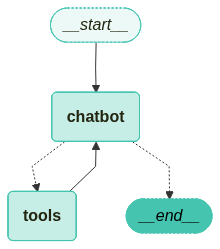

In [30]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [31]:
inputs = {"messages": "테디노트 YouTube 채널에 대해서 검색해 줘"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='테디노트 YouTube 채널에 대해서 검색해 줘' additional_kwargs={} response_metadata={} id='90a881bc-c536-44ef-87ec-b1028280d943'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_xOs3yV4DbPqt04KfSNpIAhEs', 'function': {'arguments': '{"query":"테디노트 YouTube 채널"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 114, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-ChE3wsjtvhYXScvqgjX8IlYtfLson', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-d4b6524d-8a76-4c3b-ad27-7675ea808425-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '테디노트 YouTube 채널'}, 'id': 'call_xOs3yV4DbPqt04KfSNpIAhEs

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 63652 tokens (63564 in the messages, 88 in the functions). Please reduce the length of the messages or functions.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}